In [2]:
%load_ext autoreload
%autoreload 2

In [149]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.linear_model import BayesianRidge, RidgeCV
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer, KBinsDiscretizer
from preprocessing import expand_cabin, expand_passenger_id_to_group, expand_name, impute_missing_values

sns.set_theme(palette="mako")

tfd = tfp.distributions
tfb = tfp.bijectors

DATASET_PATH = "/Users/dincaus/datasets/spaceship-titanic"

TRAIN_PATH = os.path.join(DATASET_PATH, "train.csv")
TEST_PATH = os.path.join(DATASET_PATH, "test.csv")

In [225]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [229]:
all_data = pd.concat([train_df, test_df])
all_data[["Deck", "CabinNumber", "Side"]] = expand_cabin(all_data)
all_data["PassengerGroup"] = expand_passenger_id_to_group(all_data)
all_data[["FirstName", "LastName"]] = expand_name(all_data)

all_data = all_data.drop(columns=["Cabin", ]).reset_index(drop=True)
all_data["Test"] = all_data["Transported"].apply(lambda x: True if x is np.nan else False)

last_name_mapping = pd.concat([all_data.groupby(by="LastName")["LastName"].count().rename("Count"), pd.Series([all_data.groupby(by="LastName")["LastName"].count().rename("Count").mode()[0]], index=[np.nan])])

all_data["FamilySize"] = all_data["LastName"].apply(lambda x: last_name_mapping[x])

In [230]:
BOOL_FEATURES = ["CryoSleep", "VIP"]
CATEGORICAL_FEATURES = ["HomePlanet", "Destination", "Deck", "Side", "PassengerGroup"]
NUMERICAL_FEATURES = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "CabinNumber", "FamilySize"]

In [231]:
# normalize data

all_data["RoomService"] = PowerTransformer().fit_transform(all_data["RoomService"].to_numpy().reshape(-1, 1))
all_data["FoodCourt"] = PowerTransformer().fit_transform(all_data["FoodCourt"].to_numpy().reshape(-1, 1))

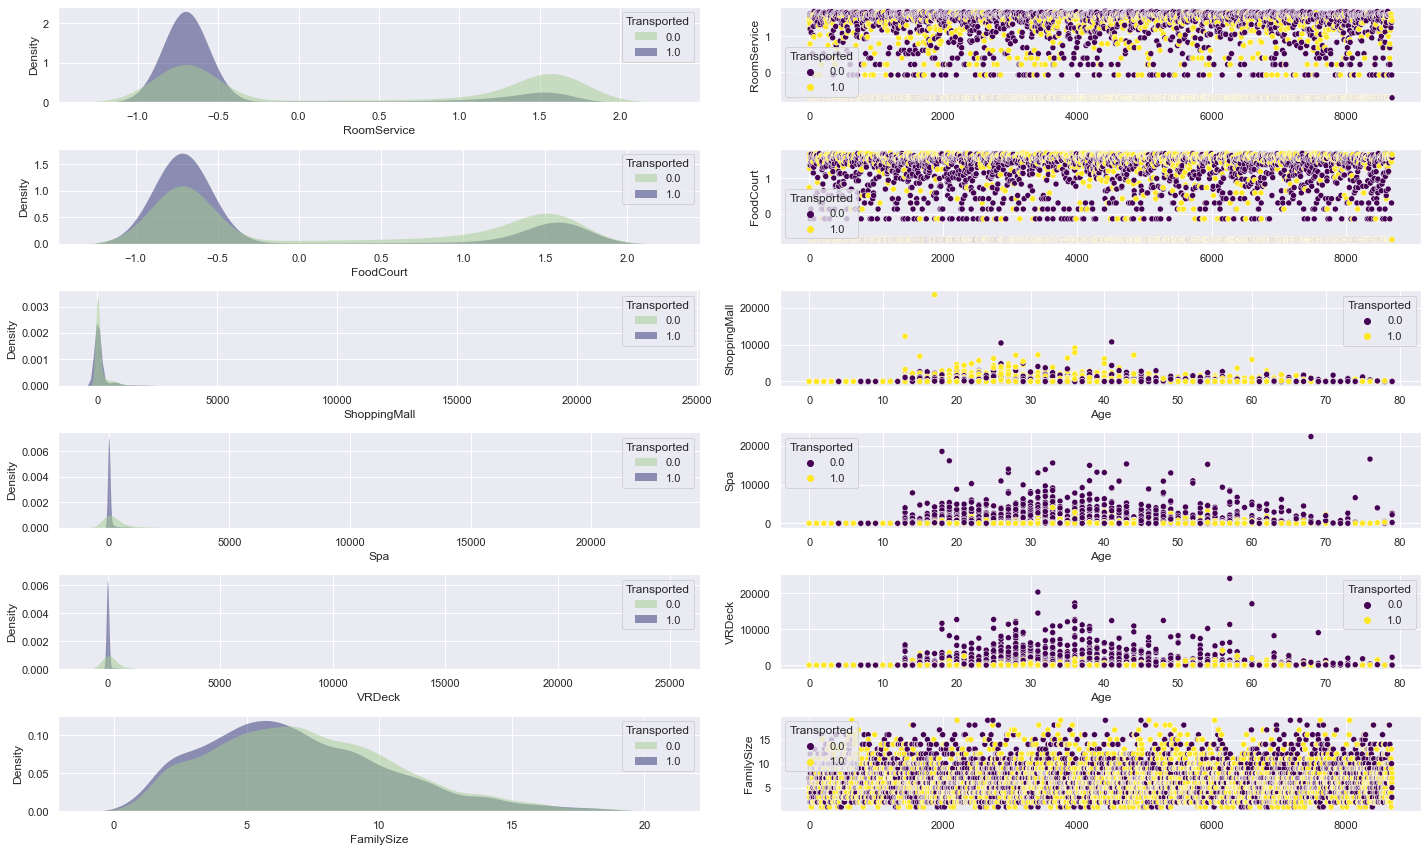

In [232]:
_, axs = plt.subplots(6, 2, figsize=(20, 12))

sns.kdeplot(data=all_data, x="RoomService", hue="Transported", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0, ax=axs[0][0])
sns.scatterplot(data=all_data, x=all_data.index, y="RoomService", hue="Transported", palette="viridis", ax=axs[0][1])

sns.kdeplot(data=all_data, x="FoodCourt", hue="Transported", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0, ax=axs[1][0])
sns.scatterplot(data=all_data, x=all_data.index, y="FoodCourt", hue="Transported", palette="viridis", ax=axs[1][1])

sns.kdeplot(data=all_data, x="ShoppingMall", hue="Transported", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0, ax=axs[2][0])
sns.scatterplot(data=all_data, x="Age", y="ShoppingMall", hue="Transported", palette="viridis", ax=axs[2][1])

sns.kdeplot(data=all_data, x="Spa", hue="Transported", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0, ax=axs[3][0])
sns.scatterplot(data=all_data, x="Age", y="Spa", hue="Transported", palette="viridis", ax=axs[3][1])

sns.kdeplot(data=all_data, x="VRDeck", hue="Transported", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0, ax=axs[4][0])
sns.scatterplot(data=all_data, x="Age", y="VRDeck", hue="Transported", palette="viridis", ax=axs[4][1])

sns.kdeplot(data=all_data, x="FamilySize", hue="Transported", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0, ax=axs[5][0])
sns.scatterplot(data=all_data, x=all_data.index, y="FamilySize", hue="Transported", palette="viridis", ax=axs[5][1])

plt.tight_layout()
plt.show()

In [233]:
# impute missing values in numerical features
knn_imputer = KNNImputer(n_neighbors=30)

all_data[NUMERICAL_FEATURES] = knn_imputer.fit_transform(all_data[NUMERICAL_FEATURES].to_numpy())

In [234]:
all_data["HomePlanet"] = LabelEncoder().fit_transform(all_data["HomePlanet"].to_numpy())
all_data["Destination"] = LabelEncoder().fit_transform(all_data["Destination"].to_numpy())
all_data["Deck"] = LabelEncoder().fit_transform(all_data["Deck"].to_numpy())
all_data["Side"] = LabelEncoder().fit_transform(all_data["Side"].to_numpy())

In [235]:
all_data["AgeDiscrete"] = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform").fit_transform(all_data["Age"].to_numpy().reshape(-1, 1))
all_data["FamilySizeDiscrete"] = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform").fit_transform(all_data["FamilySize"].to_numpy().reshape(-1, 1))

all_data["RoomServiceDiscrete"] = KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="uniform").fit_transform(all_data["RoomService"].to_numpy().reshape(-1, 1))
all_data["FoodCourtDiscrete"] = KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="uniform").fit_transform(all_data["FoodCourt"].to_numpy().reshape(-1, 1))
all_data["ShoppingMallDiscrete"] = KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="uniform").fit_transform(all_data["ShoppingMall"].to_numpy().reshape(-1, 1))

all_data["SpaDiscrete"] = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform").fit_transform(all_data["Spa"].to_numpy().reshape(-1, 1))
all_data["VRDeckDiscrete"] = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform").fit_transform(all_data["VRDeck"].to_numpy().reshape(-1, 1))

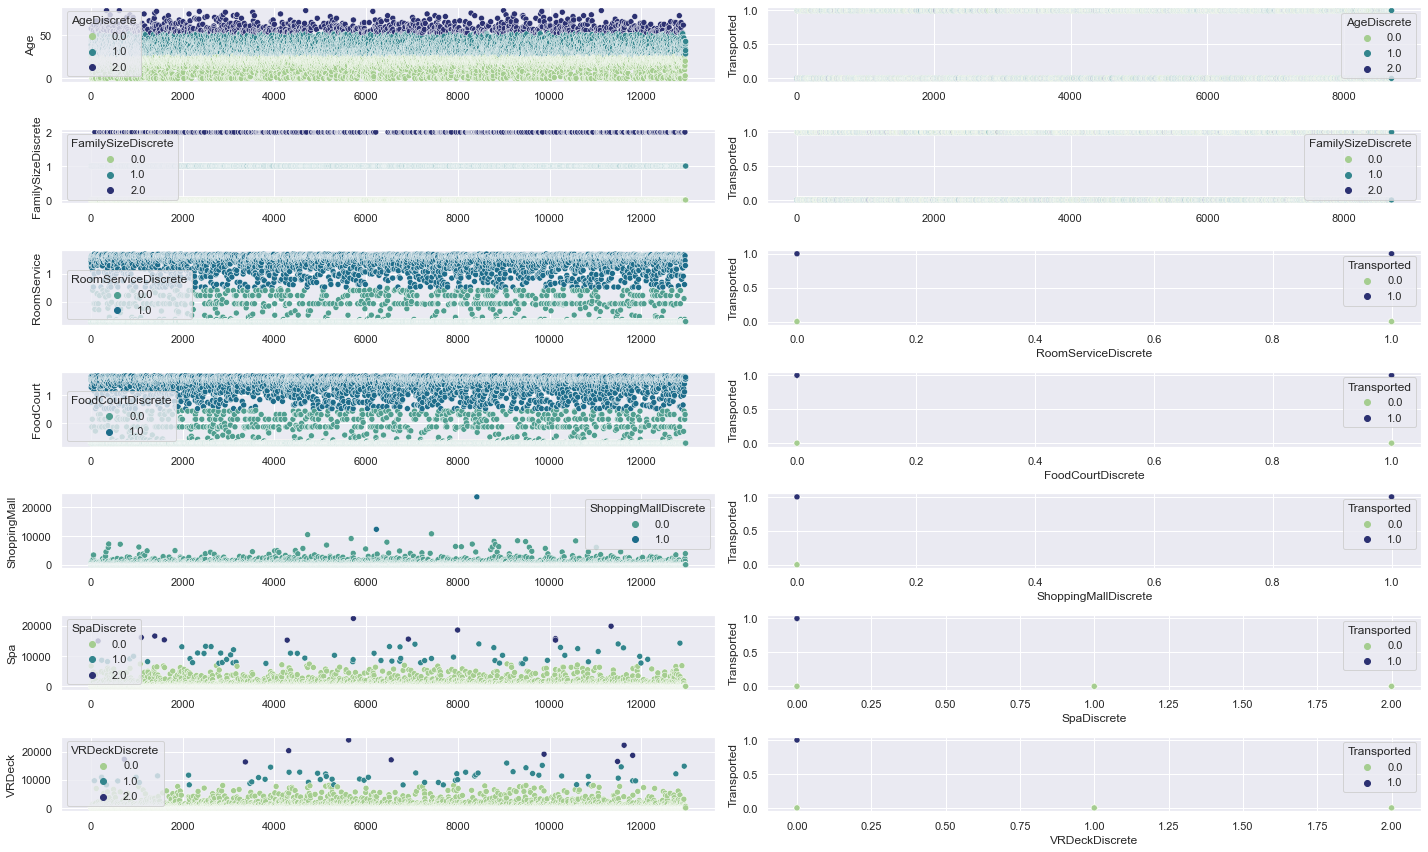

In [236]:
_, axs = plt.subplots(7, 2, figsize=(20, 12))

sns.scatterplot(data=all_data, x=all_data.index, y="Age", hue="AgeDiscrete", palette="crest", ax=axs[0][0])
sns.scatterplot(data=all_data, x=all_data.index, y="Transported", hue="AgeDiscrete", palette="crest", ax=axs[0][1])

sns.scatterplot(data=all_data, x=all_data.index, y="FamilySizeDiscrete", hue="FamilySizeDiscrete", palette="crest", ax=axs[1][0])
sns.scatterplot(data=all_data, x=all_data.index, y="Transported", hue="FamilySizeDiscrete", palette="crest", ax=axs[1][1])

sns.scatterplot(data=all_data, x=all_data.index, y="RoomService", hue="RoomServiceDiscrete", palette="crest", ax=axs[2][0])
sns.scatterplot(data=all_data, x="RoomServiceDiscrete", y="Transported", hue="Transported", palette="crest", ax=axs[2][1])

sns.scatterplot(data=all_data, x=all_data.index, y="FoodCourt", hue="FoodCourtDiscrete", palette="crest", ax=axs[3][0])
sns.scatterplot(data=all_data, x="FoodCourtDiscrete", y="Transported", hue="Transported", palette="crest", ax=axs[3][1])

sns.scatterplot(data=all_data, x=all_data.index, y="ShoppingMall", hue="ShoppingMallDiscrete", palette="crest", ax=axs[4][0])
sns.scatterplot(data=all_data, x="ShoppingMallDiscrete", y="Transported", hue="Transported", palette="crest", ax=axs[4][1])

sns.scatterplot(data=all_data, x=all_data.index, y="Spa", hue="SpaDiscrete", palette="crest", ax=axs[5][0])
sns.scatterplot(data=all_data, x="SpaDiscrete", y="Transported", hue="Transported", palette="crest", ax=axs[5][1])

sns.scatterplot(data=all_data, x=all_data.index, y="VRDeck", hue="VRDeckDiscrete", palette="crest", ax=axs[6][0])
sns.scatterplot(data=all_data, x="VRDeckDiscrete", y="Transported", hue="Transported", palette="crest", ax=axs[6][1])

plt.tight_layout()
plt.show()

In [200]:
train_data = all_data[~all_data["Transported"].isna()]

In [237]:
feature_selector = SequentialFeatureSelector(estimator=RidgeCV(alphas=np.logspace(-6, 6, num=5)), n_features_to_select=10, direction="forward")
feature_selector.fit(train_data[NUMERICAL_FEATURES + CATEGORICAL_FEATURES], train_data["Transported"])
feature_selector.get_feature_names_out()

array(['Age', 'RoomService', 'FoodCourt', 'Spa', 'VRDeck', 'HomePlanet',
       'Destination', 'Deck', 'Side', 'PassengerGroup'], dtype=object)